In [1]:
"""
This script is used for:
    - Showcasing the actual retrieval process using the trained vit transformer
    - Calculating the mAP metric using torchmetrics library
    - Analyisng the performance in terms of the histogram of mAPs over all queries from the test set, as well as analysing the best and worst performing queries.
"""

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision.utils import save_image, make_grid
from vit import *

from torchmetrics import RetrievalMAP
from torchmetrics.functional import retrieval_average_precision

/itet-stor/ddordevic/net_scratch/conda_envs/mscenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Setup: folders and models
run_on_server = True

K = 3 # return K best matching images
model_file = "vit_model_0404.pt"
database_file_train = "training_mnist.pkl"
database_file_test = "test_mnist.pkl"

img_name = "vit_mnist_grid_"

if run_on_server:
    model_folder = "/usr/itetnas04/data-scratch-01/ddordevic/data/cluster_scripts/vit_copy/model_save/"
    database_folder = "/usr/itetnas04/data-scratch-01/ddordevic/data/cluster_scripts/vit_copy/MNIST/extracted_features/"
    img_save_folder = "/usr/itetnas04/data-scratch-01/ddordevic/data/cluster_scripts/vit_copy/MNIST/test_outputs/"
else:
    model_folder =  "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/model_save/"
    database_folder = "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/extracted_features/"
    img_save_folder = "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/test_outputs/"


model_path = model_folder + model_file
database_path_train = database_folder + database_file_train
database_path_test = database_folder + database_file_test

In [5]:
# Load the database into a pandas DataFrame
# DataFrame contains the following columns: ['image','feature','label']
# The 1st columns contains a flattened image
# The training database will be used for matrix building, while the tet database will be used to fetch query images

database_train_df = pd.read_pickle(database_path_train)
database_test_df = pd.read_pickle(database_path_test)

In [6]:
# Get database length
num_images_train = len(database_train_df)
num_images_test = len(database_test_df)

In [23]:
# Fetch the train database matrix
# database_matrix = []
# for i in range(num_images_train):
#     database_matrix.append(database_train_df.iloc[i]['feature'])
# database_matrix = torch.stack(database_matrix)

database_matrix = torch.stack(tuple(database_train_df['feature'])) # much more effcient

In [26]:
a_df = pd.DataFrame({'a': [1,2],'b':[3,4]})

In [27]:
a_df

,a,b
0,1,3
1,2,4


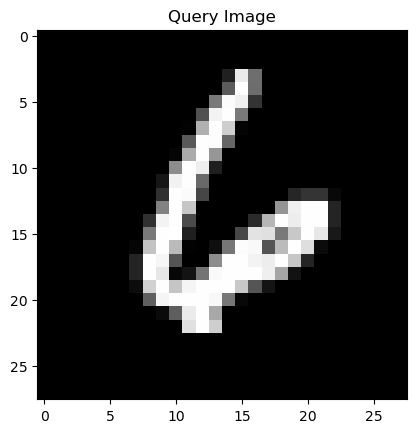

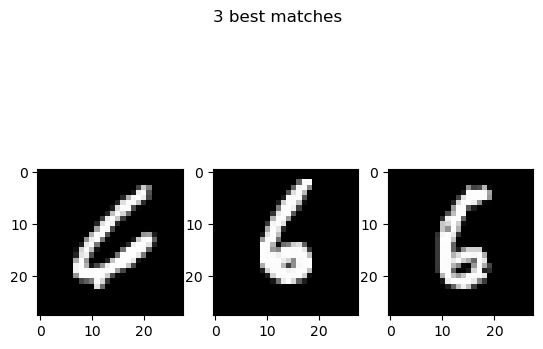

In [10]:
# Extract a random query image from the database
query_img_idx = np.random.randint(0, num_images_test)
query_img = database_test_df.iloc[query_img_idx]['image']#.unflatten(0, unflatten_shape)
query_ftrs = database_test_df.iloc[query_img_idx]['feature']
query_label = database_test_df.iloc[query_img_idx]['label']

# Multiply the database matrix and the query feature vector
match_scores = database_matrix @ query_ftrs
sorted_scores, sorted_ind = torch.sort(match_scores, descending=True)

# Take K best matches
k_best_ind = sorted_ind[0:K]

# Visualize the K best images
# Print the query image:
plt.imshow(query_img[0], cmap='gray')
plt.title('Query Image')

# Print the best matching images (according to inner product, as suggested in the paper I found)
fig, axs = plt.subplots(1, K)
fig.suptitle(f'{K} best matches')

for i, best_idx in enumerate(k_best_ind.numpy()):
    axs[i].imshow(database_train_df.iloc[best_idx]['image'][0], cmap='gray')

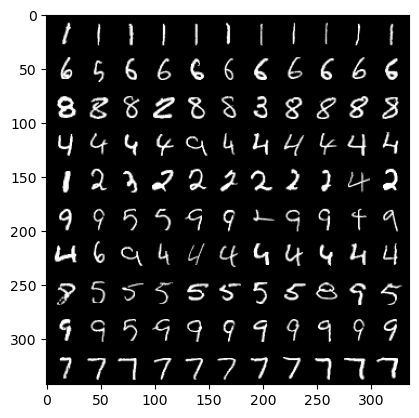

In [15]:
# Testing of the system on 5 random queries, with top-3 results taken into consideration
num_runs = 10
K = 10

big_grid = []

for i in range(num_runs):
    # Extract a random query image from the database
    query_img_idx = np.random.randint(0, num_images_test)
    query_img = database_test_df.iloc[query_img_idx]['image']#.unflatten(0, unflatten_shape)
    query_ftrs = database_test_df.iloc[query_img_idx]['feature']
    query_label = database_test_df.iloc[query_img_idx]['label']

    # Multiply the database matrix and the query feature vector (to be done for each query vector)
    match_scores = database_matrix @ query_ftrs
    sorted_scores, sorted_ind = torch.sort(match_scores, descending=True)

    # Take K best matches
    k_best_ind = sorted_ind[0:K].numpy()

    # Grid
    grid_list = [query_img]

    for j in k_best_ind:
        grid_list.append(database_train_df.iloc[j]['image'])

    grid = make_grid(grid_list, nrow=K+1)
    big_grid.append(grid)

    # Save images to img_save_folder
    # img_path = img_save_folder + img_name + str(i) + '.png'
    # save_image(grid, img_path)

big_grid = make_grid(big_grid, nrow=1)
save_image(big_grid, img_save_folder + img_name + 'big.png')

plt.imshow(big_grid.permute(1,2,0))

In [11]:
# Calculating the MAP: (This cell is an old approach - it's manual, does not work well, accurate and is not efficient space-wise)
# Requires first calculating the match scores, sorting them, and then returning the order of the indices according to the highest scores.
# Indices are then also transformed into corresponding label list, with each entry corresponsing to the class that each index from the list belongs to.
# List is also turned into a binary vector sorted_relevant_docs, with 1 being on positions of relevant images for the given query, and 0 otherwise.

# UPDATED: If using RetrevalMAP from torchmetrics, there is no need to sort the scores. The only thing needed to evaluate the MAP of a retrieval system
# is to calculate the match_scores for each query, stack them, make corresponding query vectors (basically assign a number to each query), and binary
# vectors that tell us which query entry is the correct one (True/False vector). 
  
match_scores = database_matrix @ query_ftrs
sorted_scores, sorted_ind = torch.sort(match_scores, descending=True)

sorted_labels = database_train_df['label'][sorted_ind.numpy()]
for i, item in enumerate(sorted_labels):
    sorted_labels[i] = sorted_labels[i].item()
    
sorted_labels = sorted_labels.to_numpy()
sorted_relevant_docs = torch.Tensor(sorted_labels.astype(int)) == query_label

# Calculating the mAP using RetrievalMAP object

Note: Does not work because it requires a lot of memory.

In [52]:
# Load all test set query features into a single matrix X. All features are vertically stacked.
queries_ftrs = torch.column_stack(tuple(database_test_df['feature']))

# Get the score vectors stacked vertically. Each column corresponds to the score vector of one query. Size NxQ, N = # images in database, Q = # queries
preds = database_matrix @ queries_ftrs

# Transpose the score matrix S, so that each row corresponds to one query. This is our preds matrix for the MAP function.
preds = preds.T

# Go over the test dataset the same order as it is in the dataframe
queries_labels = torch.tensor(database_test_df['label'])

database_labels = torch.tensor(database_train_df['label'])

targets = torch.full_like(preds, True)
for i in range(targets.shape[0]):
    targets[i] = torch.where(database_labels == query_label, True, False)

# Make a matrix of indexes
# Each vector inside the matrix needs to contain just one number - the order of the query. The length of the vector is the 
# length of the given query search result list: in this case that is the length of the training database.
# The height of the matrix (i.e. the number of vectors inside the matrix) is equal to the number of queries: in this case
# that is the number of images in the test dataset.

m_height, m_width = preds.shape
# m_width = num_images_train
# m_height = num_images_test

index_column = torch.arange(0, m_height)
index_matrix = torch.column_stack([index_column]*m_width)

# Now that we have the predictions (preds), the index matrix (index_matrix) and the targets (targets), we can calculate the mAP:
rmap = RetrievalMAP()
rmap(preds, targets, indexes=index_matrix)

# Alternative: manual mAP calculation
(using retreival_average_precision function)

In [27]:
# How this function works is that you enter the (unsorted) matching scores that the retrieval system has outputted for a given query.
# The function then sorts the scores and calculates the Average Precision of the query exactly as is described in the papers and the thesis report.
# The prediction scores themselves don't matter as long as they produce the same ranking (e.g. in the example below it doesn't matter whether the
# predictions will be [0.2, 0.3, 0.6] or [0.1, 0.3, 0.6], they will both produce the same AP as the ranking stays the same).
 
# preds = torch.tensor([0.1, 0.3, 0.6])
# target = torch.tensor([True, False, True])
# retrieval_average_precision(preds, target)

# How the total retrieval MAP works is by building the RetrievalMAP object and calling it upon three arguments: the predictions, targets and indexes.
# All of these input tensors can be of shape (N, ) where N is the number of queries that are tested. They can also be flat vectors.
# Indexes hold for each element the number of the query that is tested. This is because the function will flatten all input tensors, so with 
# indexes we know which entry belongs to which query, when sorted. It computes the AP for each query and then just averages them.
#   It can be used instead of retrieval_average_precision from torchmetrics.functional, if the input is just a single query.

# indexes = torch.tensor([[0, 0, 0, 0], [1, 1, 1, 1]])
# preds = torch.tensor([[0.1, 0.2, 0.5, 0.3], [0.1, 0.3, 0.5, 0.2]])
# target = torch.tensor([[False, False, False, True], [False, True, False, True]])
# target = torch.tensor([[0, 0, 0, 1], [0, 1, 0, 1]]) # same as True/False
# rmap = RetrievalMAP()
# rmap(preds, target, indexes=indexes)

tensor(0.5417)

In [18]:
# Calculate the average precision for each query in the test set and save in a tensor for further analysis
ap_test_set = torch.zeros(num_images_test)

for i in tqdm(range(num_images_test)):
    query_img = database_test_df.iloc[i]['image']#.unflatten(0, unflatten_shape)
    query_ftrs = database_test_df.iloc[i]['feature']
    query_label = database_test_df.iloc[i]['label']

    database_labels = torch.tensor(database_train_df['label'])
    target = torch.where(database_labels == query_label, True, False)

    # Multiply the database matrix and the query feature vector
    preds = database_matrix @ query_ftrs

    ap_test_set[i] = retrieval_average_precision(preds, target)

100%|██████████| 10000/10000 [22:31<00:00,  7.40it/s]


In [19]:
# Save the average precision for all queries from the test set, for easier access and analysis
torch.save(ap_test_set, model_folder + 'avg_precision_test_set.pkl')

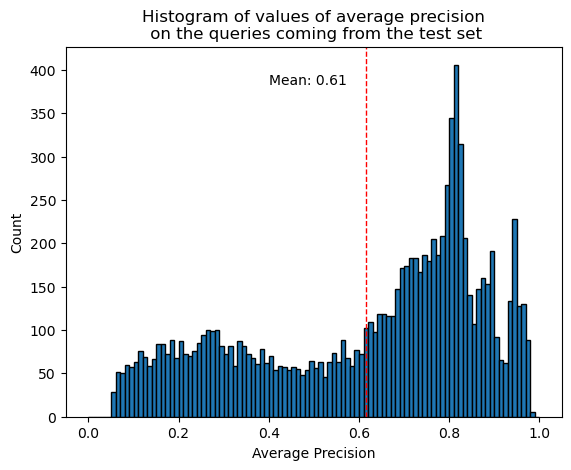

In [20]:
# Plot the histogram of average precisions:
reuslt = plt.hist(ap_test_set.numpy(), bins=100, range=(0,1), edgecolor='k')
plt.xlabel('Average Precision')
plt.ylabel('Count')
plt.title('Histogram of values of average precision\n on the queries coming from the test set')
plt.axvline(ap_test_set.mean(), color='r', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(ap_test_set.mean()*0.65, max_ylim*0.9, 'Mean: {:.2f}'.format(ap_test_set.mean()))
plt.savefig(model_folder+'histogram_of_precisions.png', dpi=300)

Text(0.5, 1.0, 'Query Image with the highest average precision')

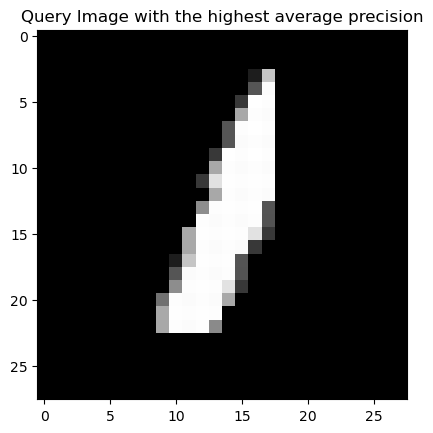

In [21]:
# Plot the image that achieved the highest average precision
max_ap = ap_test_set.max()
max_idx = ap_test_set.argmax()

best_query_img = database_test_df.iloc[max_idx.item()]['image']
best_query_label = database_test_df.iloc[max_idx.item()]['label']

plt.imshow(best_query_img[0], cmap='gray')
plt.title('Query Image with the highest average precision')

Text(0.5, 1.0, 'Query Image with the lowest average precision')

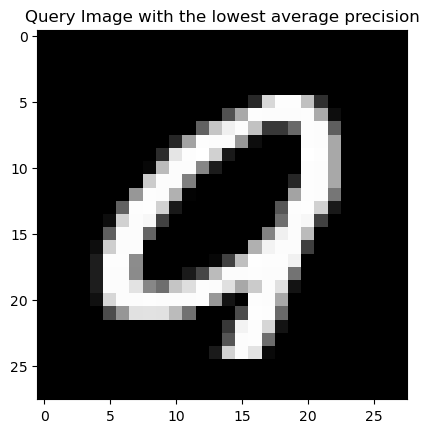

In [22]:
# Plot the image that achieved the lowest average precision
min_ap = ap_test_set.min()
min_idx = ap_test_set.argmin()

worst_query_img = database_test_df.iloc[min_idx.item()]['image']
worst_query_label = database_test_df.iloc[min_idx.item()]['label']

plt.imshow(worst_query_img[0], cmap='gray')
plt.title('Query Image with the lowest average precision')